In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras import layers
from keras.layers import Input, Dense, Activation, BatchNormalization
from keras.layers import  Dropout 
from keras.models import Model
from keras import regularizers, optimizers
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K
from keras.initializers import glorot_uniform
from keras.callbacks import TensorBoard
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler
from sklearn.preprocessing import Normalizer,MaxAbsScaler,RobustScaler
from sklearn.model_selection import cross_val_score
import shap
import seaborn as sns
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation
from sklearn.ensemble import RandomForestClassifier
import lime
import lime.lime_tabular

In [3]:
font = {'family' : 'serif',
        'size'   : 10}

mpl.rc('font', **font)

# Random draws from 8 guassian rvs

In [4]:
np.random.seed=2
X=np.random.randn(8,1000)

# Fitting a linear model on the drawn samples

In [5]:
Y=1*X[0,] + 2*X[1,] - 3*X[2,] - 4*X[3,] + 5*X[4,] + 6*X[5,] + 7*X[6,] + 10 * X[7,]

[<matplotlib.lines.Line2D at 0x2ae636f4ca20>]

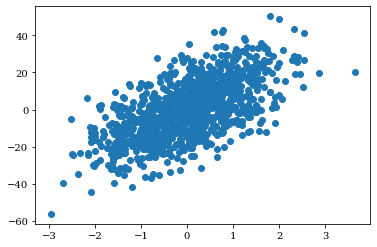

In [6]:
plt.plot(X[7,],Y,'o')

# Splitting the data to train,test,split

In [7]:
sc = StandardScaler()
X_std=sc.fit_transform(X.T)

In [8]:
df_X_std=pd.DataFrame(data=X_std)

In [9]:
test_size=0.30
rand_state=11

q0=-100
q1=np.percentile(Y,25.0)
q2=np.percentile(Y,50.0)
q3=np.percentile(Y,75.0)
q4=100

bins=[q0,q1,q2,q3,q4]

y_binned = np.digitize(Y, bins=bins,right=True)

X_train, X_dev_test, y_train, y_dev_test = train_test_split(df_X_std,Y,stratify=y_binned,
                                             test_size=test_size, shuffle=True,random_state=rand_state)

X_dev, X_test, y_dev, y_test = train_test_split(X_dev_test,y_dev_test,
                                             test_size=0.5, shuffle=False,random_state=rand_state)

# Deep model

In [10]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [11]:
def model(input_shape):
    X_input=Input(shape=input_shape)
    X=Dense(64,name='layer_1',activation='tanh',kernel_initializer = glorot_uniform(seed=0))(X_input)
    X=Dropout(0.25)(X)
    X=Dense(64,name='layer_2',activation='tanh',kernel_initializer = glorot_uniform(seed=0))(X)
    X=Dropout(0.25)(X)
#     X=Dense(64,name='layer_3',activation='tanh',kernel_initializer = glorot_uniform(seed=0))(X)
#     X=Dropout(0.25)(X)
#     X=Dense(64,name='layer_4',activation='tanh',kernel_initializer = glorot_uniform(seed=0))(X)
#     X=Dropout(0.25)(X)
    X=Dense(1 ,name='output',activation='linear')(X)
    model = Model(inputs = X_input, outputs = X, name='PhaseModel')
    model.summary()
    return model

In [45]:
model1=model((X_std.shape[1],))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
layer_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
layer_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [46]:
Adam=optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model1.compile(optimizer=Adam,
               loss='mean_squared_error', 
               metrics=[coeff_determination])

## Training

In [47]:
R2_train=[]
R2_dev=[]
R2_test=[]

In [ ]:
for i in range(300):
    model1.fit(X_train, y_train,
                  batch_size=1000,
                  epochs=50,
                  validation_data=(X_dev, y_dev),
                  shuffle=False,
                  verbose=0)
    R2_train.append(model1.evaluate(X_train,y_train)[1])
    R2_dev.append(model1.evaluate(X_dev,y_dev)[1])
    R2_test.append(model1.evaluate(X_test,y_test)[1])

# Results

## $R^2$

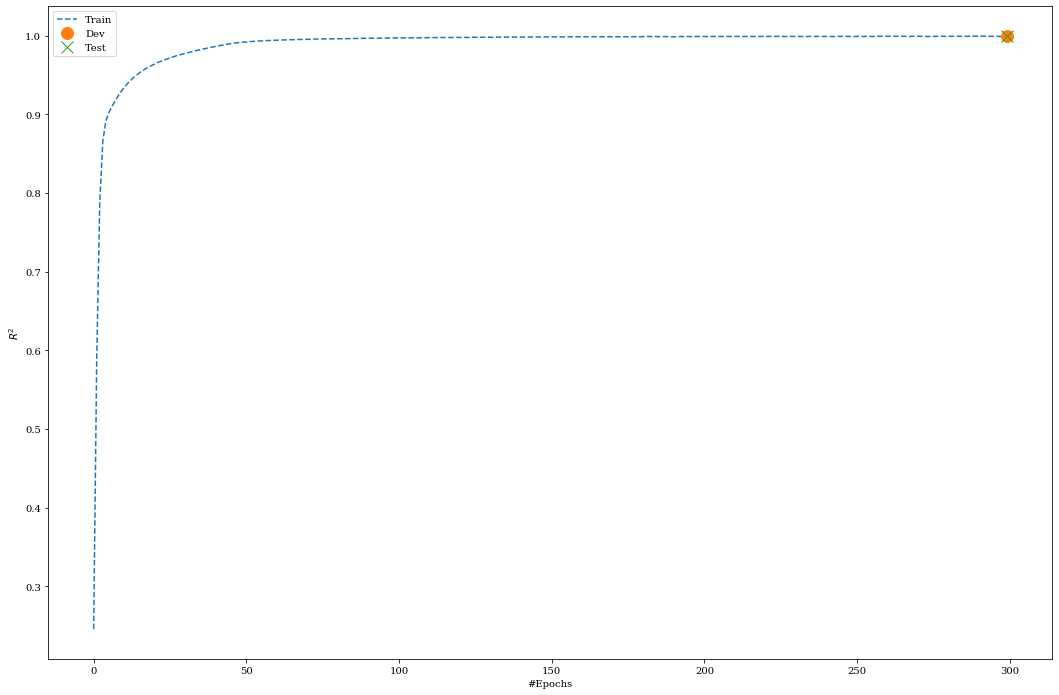

In [49]:
n_epochs=np.arange(len(R2_train))
plt.figure(figsize=(18,12))
plt.plot(n_epochs,R2_train,'--',label='Train')
plt.plot(n_epochs[-1],R2_dev[-1],'o',markersize=12,label='Dev')
plt.plot(n_epochs[-1],R2_test[-1],'x',markersize=12,label='Test')
#plt.ylim((0.5,1))
plt.ylabel(r'$R^2$')
plt.xlabel('#Epochs')
plt.legend()
plt.show()

## Predicted vs true values

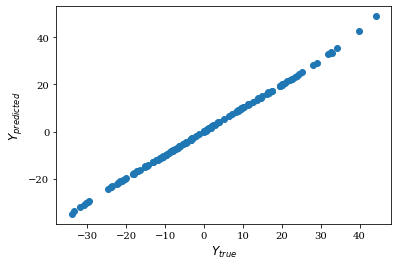

In [50]:
y_pred_test=model1.predict(X_test)
plt.plot(y_pred_test,y_test,'o')
plt.xlabel(r'$Y_{true}$',fontsize=12)
plt.ylabel(r'$Y_{predicted}$',fontsize=12)
plt.show()

# Feature importance

## SHAP explainer

In [51]:
#backgournd=shap.kmeans(X_train,10)
backgournd=X_train
explainer = shap.KernelExplainer(model1.predict, backgournd)

Using 700 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [61]:
shap_values= explainer.shap_values(X_test.iloc[0:50])

  0%|          | 0/50 [00:00<?, ?it/s]/home/arashs/.local/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
100%|██████████| 50/50 [01:47<00:00,  2.11s/it]


In [65]:
df_shap_values=pd.DataFrame(data=shap_values[0],
                            columns=['var_'+str(i) for i in range(8)],
                            index=['sample_'+str(i) for i in range(shap_values[0].shape[0])])

### Local SHAP values (for a single instance)

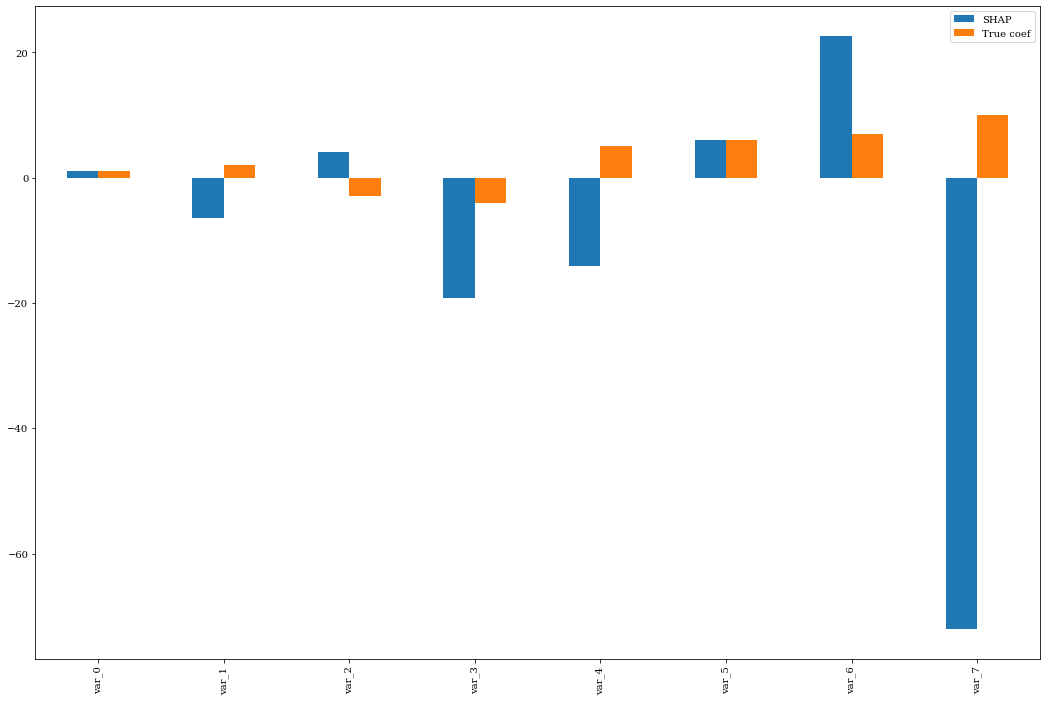

In [66]:
idx=7   ## Index of the desired sample instance
local_shap_vs_true_coef=pd.DataFrame(index=df_shap_values.columns)
local_shap_vs_true_coef['SHAP']=df_shap_values.iloc[idx].values/df_shap_values.iloc[idx,0]
local_shap_vs_true_coef['True coef']=[1,2,-3,-4,5,6,7,10]
local_shap_vs_true_coef.plot(kind='bar',figsize=(18,12))
plt.show()

### Global SHAP (averaged over X_test)

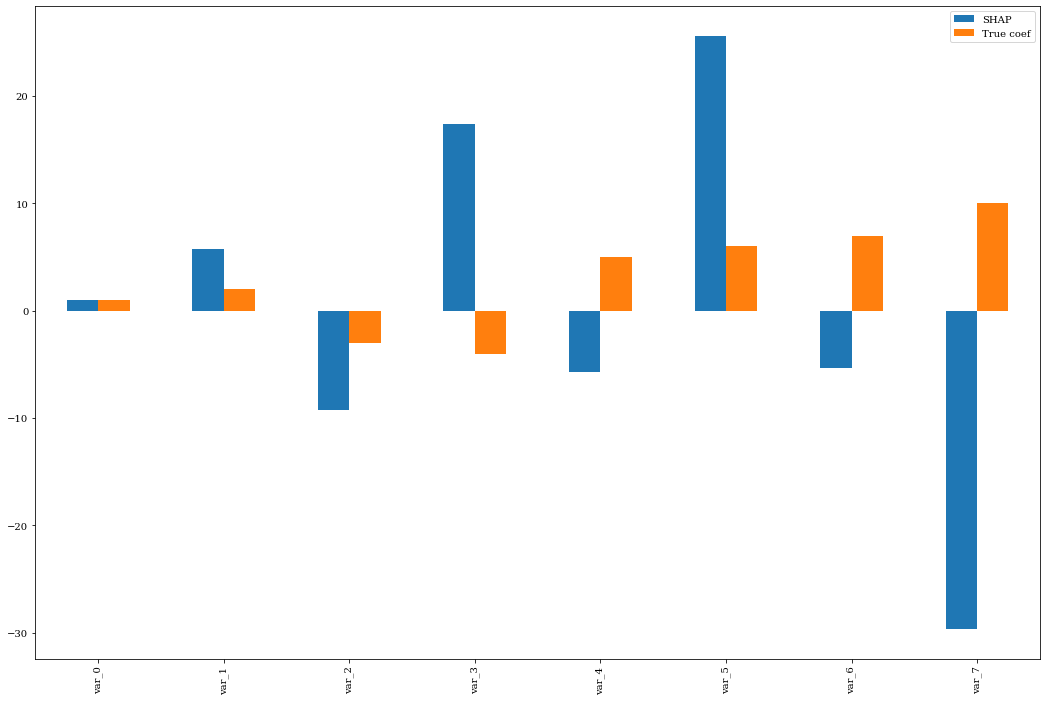

In [67]:
Global_shap_vs_true_coef=pd.DataFrame(index=df_shap_values.columns)
Global_shap_vs_true_coef['SHAP']=df_shap_values.mean(axis=0)
Global_shap_vs_true_coef['SHAP']=Global_shap_vs_true_coef['SHAP']/Global_shap_vs_true_coef['SHAP'].iloc[0]
Global_shap_vs_true_coef['True coef']=[1,2,-3,-4,5,6,7,10]
Global_shap_vs_true_coef.plot(kind='bar',figsize=(18,12))

### Global Absolute SHAP (averaged over X_test)

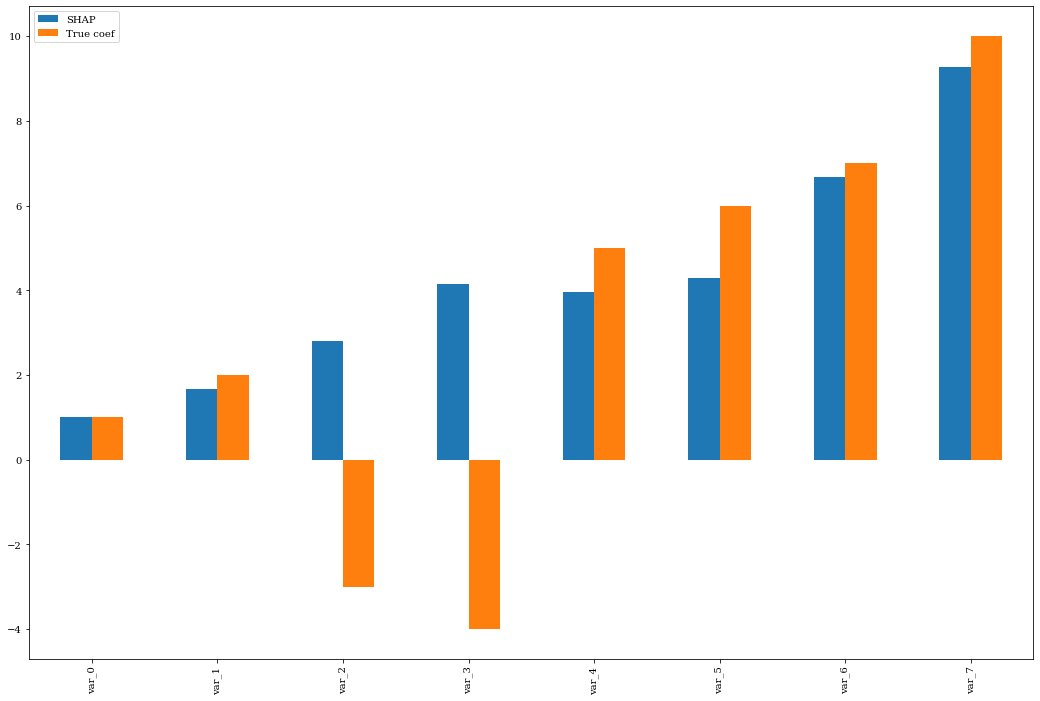

In [68]:
Global_abs_shap_vs_true_coef=pd.DataFrame(index=df_shap_values.columns)
Global_abs_shap_vs_true_coef['SHAP']=np.abs(df_shap_values).mean(axis=0)
Global_abs_shap_vs_true_coef['SHAP']=Global_abs_shap_vs_true_coef['SHAP']/Global_abs_shap_vs_true_coef['SHAP'].iloc[0]
Global_abs_shap_vs_true_coef['True coef']=[1,2,-3,-4,5,6,7,10]
Global_abs_shap_vs_true_coef.plot(kind='bar',figsize=(18,12))

## Deep SHAP

In [76]:
Deep_background=X_train
Deep_exp=shap.DeepExplainer(model1, Deep_background)

In [77]:
Deep_shap_values = Deep_exp.shap_values(X_test.values)

In [78]:
df_Deep_shap_values=pd.DataFrame(data=Deep_shap_values[0],
                            columns=X_test.columns,
                            index=X_test.index)

### local Deep SHAP

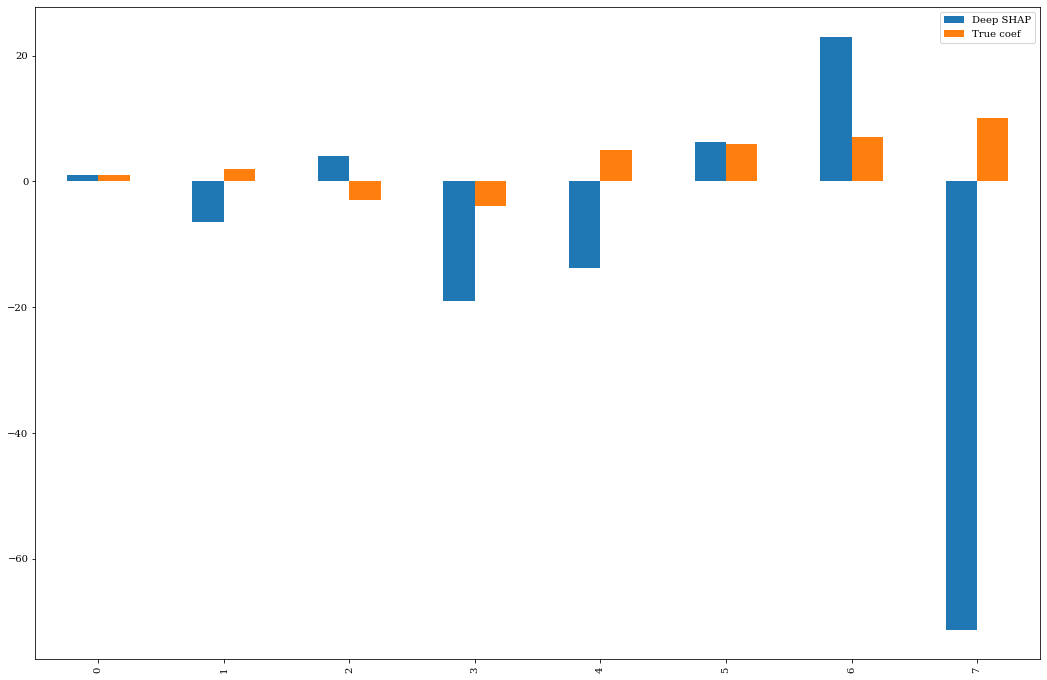

In [82]:
idx=7   ## Index of the desired sample instance
local_shap_vs_true_coef=pd.DataFrame(index=df_Deep_shap_values.columns)
local_shap_vs_true_coef['Deep SHAP']=df_Deep_shap_values.iloc[idx].values/df_Deep_shap_values.iloc[idx,0]
local_shap_vs_true_coef['True coef']=[1,2,-3,-4,5,6,7,10]
local_shap_vs_true_coef.plot(kind='bar',figsize=(18,12))
plt.show()

### GLobal Deep SHAP

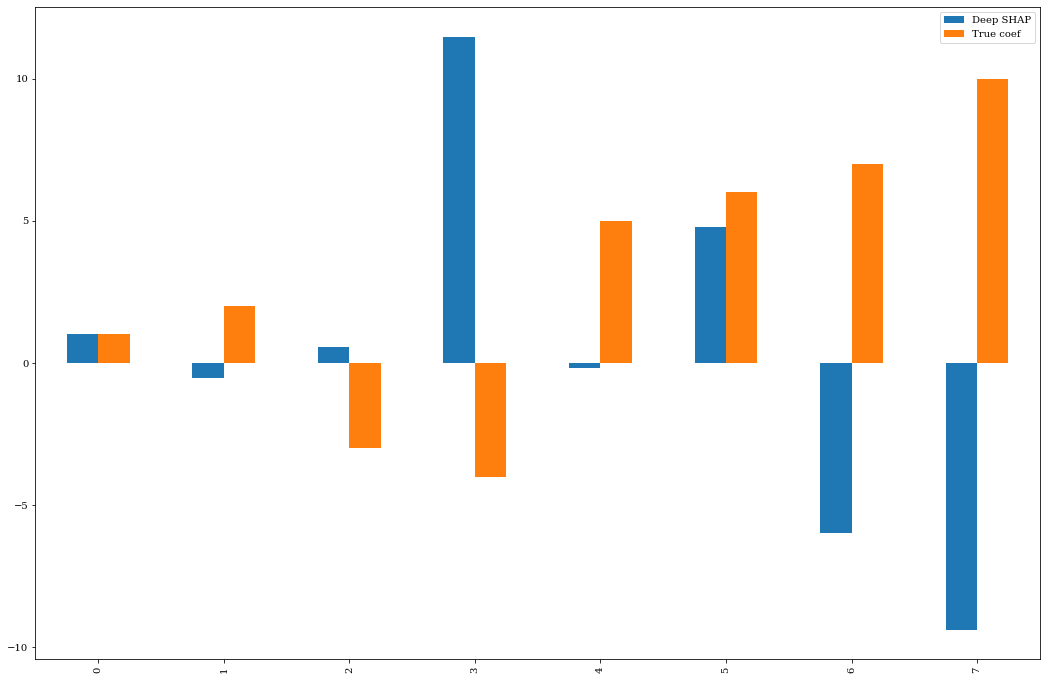

In [84]:
Global_shap_vs_true_coef=pd.DataFrame(index=df_Deep_shap_values.columns)
Global_shap_vs_true_coef['Deep SHAP']=df_Deep_shap_values.mean(axis=0)
Global_shap_vs_true_coef['Deep SHAP']=Global_shap_vs_true_coef['Deep SHAP']/Global_shap_vs_true_coef['Deep SHAP'].iloc[0]
Global_shap_vs_true_coef['True coef']=[1,2,-3,-4,5,6,7,10]
Global_shap_vs_true_coef.plot(kind='bar',figsize=(18,12))

### Global absolute Deep SHAP

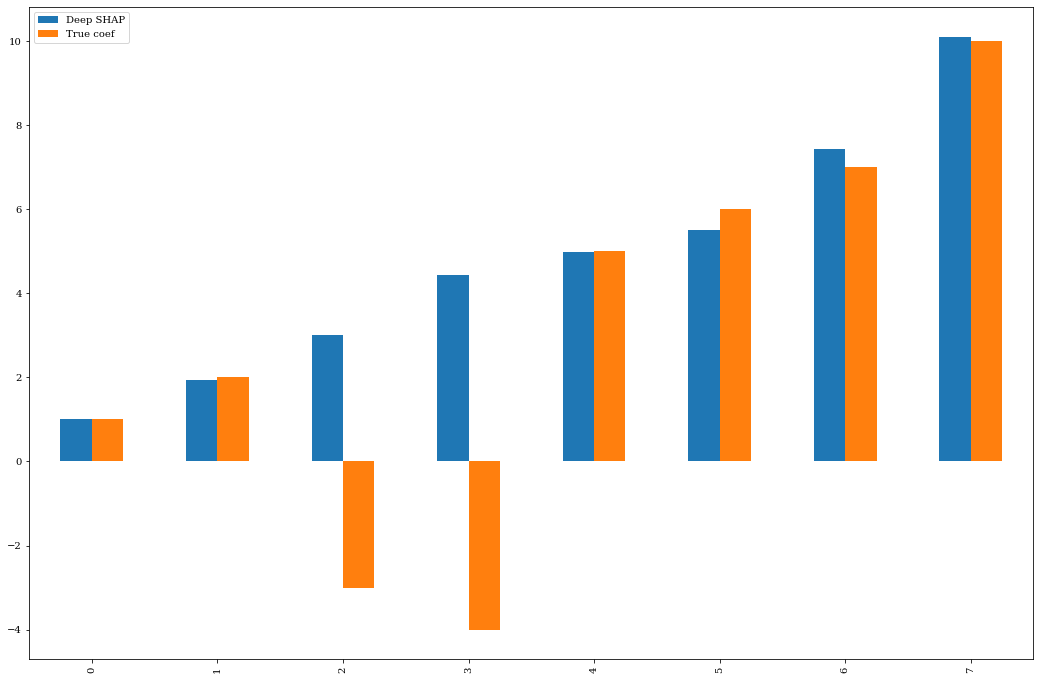

In [85]:
Global_abs_shap_vs_true_coef=pd.DataFrame(index=df_Deep_shap_values.columns)
Global_abs_shap_vs_true_coef['Deep SHAP']=np.abs(df_Deep_shap_values).mean(axis=0)
Global_abs_shap_vs_true_coef['Deep SHAP']=Global_abs_shap_vs_true_coef['Deep SHAP']/Global_abs_shap_vs_true_coef['Deep SHAP'].iloc[0]
Global_abs_shap_vs_true_coef['True coef']=[1,2,-3,-4,5,6,7,10]
Global_abs_shap_vs_true_coef.plot(kind='bar',figsize=(18,12))

In [69]:
# def lime_pred(x,model=model1):
#     out=model.predict(x)
#     return out.squeeze()

In [70]:
# lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=list(df_X_std.columns), 
#                                                    #class_names=y_train,
#                                                    verbose=False, 
#                                                    mode='regression',
#                                                   discretize_continuous=False)

In [ ]:
# y_true=[]
# y_lime=[]
# for i in range(0,Y.shape[0],10):
#     lime_exp = lime_explainer.explain_instance(df_X_std.iloc[i].values, lime_pred)
#     y_true.append(Y[i])
#     y_lime.append(lime_exp.local_pred[0])

In [ ]:
# x_dummy=np.arange(-50,50,0.1)
# plt.figure(figsize=(18,12))
# plt.plot(y_true,y_lime,'o',alpha=0.5)
# plt.plot(x_dummy,x_dummy,'--')
# plt.ylabel(r'$Y_{LIME}$')
# plt.xlabel(r'$Y_{True}$')
# plt.show()

# Local LIME values (local:for a single data instance)

In [ ]:
# exp = lime_explainer.explain_instance(X_test.iloc[3,:], lime_pred)
# exp.show_in_notebook(show_table=True)

In [ ]:
# lime_vals=[val[1] for val in exp.as_list()]
# lime_vals.reverse()
# lime_vs_true_coef=pd.DataFrame(index=df_shap_values.columns)
# lime_vs_true_coef['LIME']=lime_vals
# lime_vs_true_coef['True coef']=[1,2,-3,-4,5,6,7,10]
# lime_vs_true_coef.plot(kind='bar',figsize=(18,12))

# SKATER

In [ ]:
# skater_pred_model = InMemoryModel(model1.predict)
# interpreter = Interpretation()
# interpreter.load_data(df_X_std)
# imp=interpreter.feature_importance.feature_importance(skater_pred_model)

In [ ]:
# plt.bar(n,imp/imp[0])